In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from itertools import product

In [4]:
splits = {'train': 'emnist-letters/train-00000-of-00001.parquet', 'test': 'emnist-letters/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/tanganke/emnist_letters/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/tanganke/emnist_letters/" + splits["test"])

In [9]:
from PIL import Image
import io

def load_image_from_dict(img_dict):
    if isinstance(img_dict, dict):
        img_bytes = img_dict.get('bytes', img_dict.get('path', None))
        if isinstance(img_bytes, bytes):
            img = Image.open(io.BytesIO(img_bytes)).convert('L')
        else:
            img = Image.new('L', (28, 28))
    else:
        img = img_dict
    
    return np.array(img, dtype=np.uint8)

Y_train = df_train['label'].values
X_train = np.array([load_image_from_dict(img).reshape(28, 28, 1) for img in df_train['image']])

Y_test = df_test['label'].values
X_test = np.array([load_image_from_dict(img).reshape(28, 28, 1) for img in df_test['image']])

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (124800, 28, 28, 1)
Y_train shape: (124800,)
X_test shape: (20800, 28, 28, 1)
Y_test shape: (20800,)


In [10]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [11]:
Y_train = to_categorical(Y_train, num_classes = 26)
Y_test = to_categorical(Y_test, num_classes = 26)

In [12]:
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X_train, Y_train, test_size = 0.15, random_state = 2, stratify = Y_train.argmax(axis=1)
)

print("\nAfter split:")
print("x_train shape:", X_train.shape)
print("x_validation shape:", X_validation.shape)
print("y_train shape:", Y_train.shape)
print("y_validation shape:", Y_validation.shape)


After split:
x_train shape: (106080, 28, 28, 1)
x_validation shape: (18720, 28, 28, 1)
y_train shape: (106080, 26)
y_validation shape: (18720, 26)


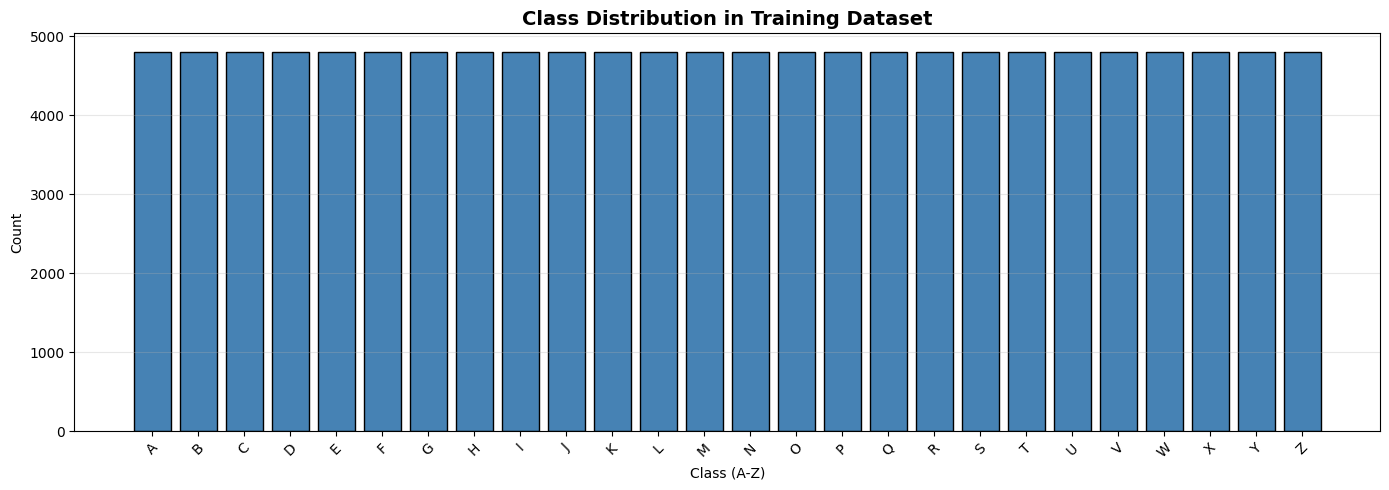

In [13]:
alpha = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
unique, counts = np.unique(Y_train_raw, return_counts=True)

plt.figure(figsize=(14, 5))
plt.bar(alpha, counts, color='steelblue', edgecolor='black')
plt.title('Class Distribution in Training Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Class (A-Z)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.12),
    layers.RandomTranslation(0.12, 0.12),
    layers.RandomContrast(0.12)
], name="data_augmentation")

I0000 00:00:1765061824.024294      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [15]:
def preprocess_for_vgg(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)
    return image, label

BATCH = 16

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = (
    train_ds.shuffle(10000)
            .map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
            .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH)
            .prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((X_validation, Y_validation))
val_ds = (
    val_ds.map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH)
          .prefetch(tf.data.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = (
    test_ds.map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE)
)

print("\nDataset batches:")
print("Training batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Dataset batches:
Training batches: 6630
Validation batches: 1170
Test batches: 1300


In [17]:
l2 = tf.keras.regularizers.l2(1e-4)
model = models.Sequential()

model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2, input_shape=(224,224,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(26, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 512)    │         2,04

 Total params: 46,281,818 (176.55 MB)

 Trainable params: 46,267,738 (176.50 MB)

 Non-trainable params: 14,080 (55.00 KB)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/10


I0000 00:00:1765061868.684412     133 service.cc:148] XLA service 0x7a7a2c014490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765061868.685306     133 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765061871.123252     133 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/6630 ━━━━━━━━━━━━━━━━━━━━ 62:56:28 34s/step - accuracy: 0.0000e+00 - loss: 5.7996

I0000 00:00:1765061889.291357     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6630/6630 ━━━━━━━━━━━━━━━━━━━━ 1685s 249ms/step - accuracy: 0.4568 - loss: 2.5807 - val_accuracy: 0.8921 - val_loss: 0.8307 - learning_rate: 1.0000e-04
Epoch 2/10
6630/6630 ━━━━━━━━━━━━━━━━━━━━ 1619s 244ms/step - accuracy: 0.7893 - loss: 1.1705 - val_accuracy: 0.9316 - val_loss: 0.6337 - learning_rate: 1.0000e-04
Epoch 3/10
6630/6630 ━━━━━━━━━━━━━━━━━━━━ 1568s 236ms/step - accuracy: 0.8563 - loss: 0.8432 - val_accuracy: 0.9354 - val_loss: 0.4937 - learning_rate: 1.0000e-04
Epoch 4/10
6630/6630 ━━━━━━━━━━━━━━━━━━━━ 1561s 235ms/step - accuracy: 0.8812 - loss: 0.6532 - val_accuracy: 0.9341 - val_loss: 0.4252 - learning_rate: 1.0000e-04
Epoch 5/10
6630/6630 ━━━━━━━━━━━━━━━━━━━━ 1559s 235ms/step - accuracy: 0.8939 - loss: 0.5502 - val_accuracy: 0.9417 - val_loss: 0.3606 - learning_rate: 1.0000e-04
Epoch 6/10
6630/6630 ━━━━━━━━━━━━━━━━━━━━ 1559s 235ms/step - accuracy: 0.8977 - loss: 0.5026 - val_accuracy: 0.9326 - val_loss: 0.3720 - learning_rate: 1.0000e-04
Epoch 7/10
6630/6630 ━━━━━━━━━━━━

In [19]:
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(np.vstack([y for x, y in test_ds]), axis=1)

accuracy = np.mean(y_pred == y_true)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n=== Model Performance ===")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall) 
print("F1-score :", f1)

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred))

1300/1300 ━━━━━━━━━━━━━━━━━━━━ 73s 55ms/step

=== Model Performance ===
Accuracy : 0.9402884615384616
Precision: 0.9436818273437872
Recall   : 0.9402884615384616
F1-score : 0.9395259239547422

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       800
           1       0.98      0.97      0.98       800
           2       0.97      0.97      0.97       800
           3       0.95      0.97      0.96       800
           4       0.97      0.98      0.98       800
           5       0.99      0.97      0.98       800
           6       0.89      0.85      0.87       800
           7       0.97      0.95      0.96       800
           8       0.65      0.88      0.75       800
           9       0.95      0.96      0.96       800
          10       0.98      0.99      0.98       800
          11       0.85      0.54      0.66       800
          12       0.97      1.00      0.98       800
          13       0

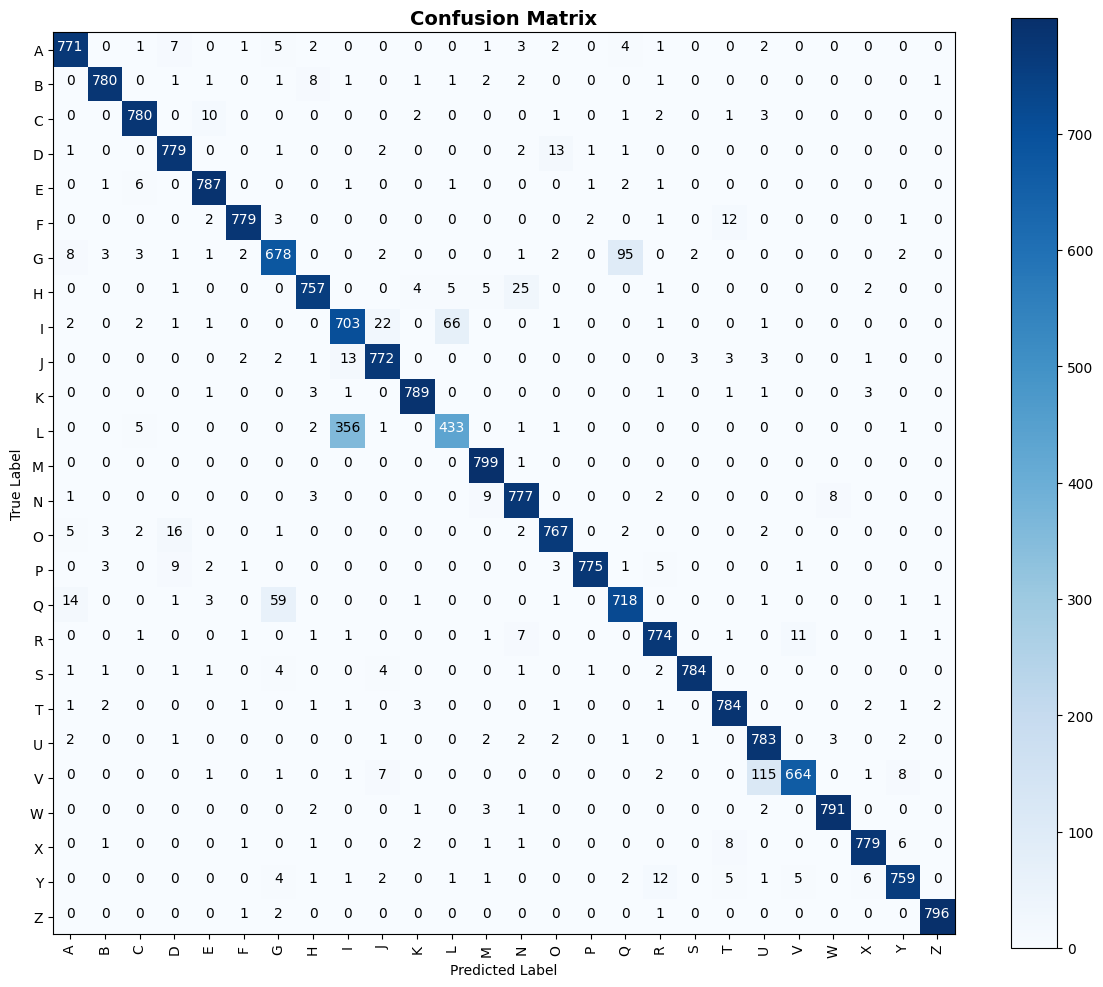

In [20]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
plt.colorbar()

classes = [chr(i) for i in range(65, 91)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

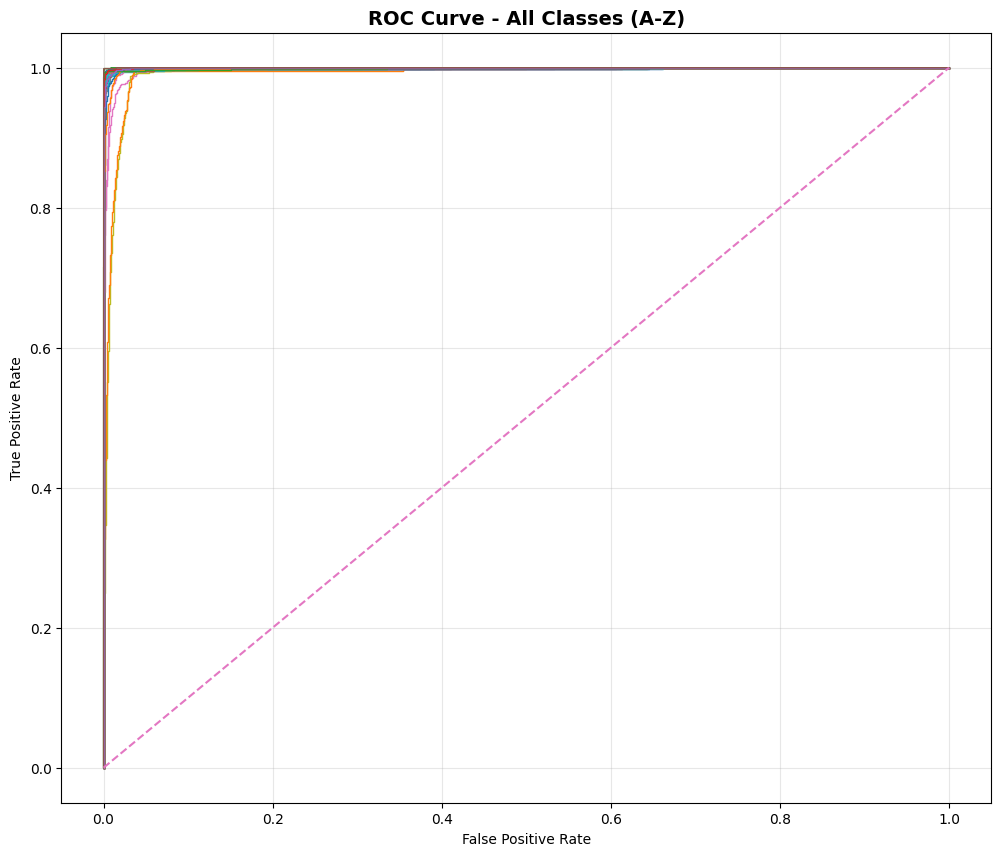

In [21]:
fpr = {}
tpr = {}
roc_auc = {}

y_true_onehot = np.zeros((len(y_true), 26))
for i, label in enumerate(y_true):
    y_true_onehot[i, label] = 1

for i in range(26):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
for i in range(26):
    plt.plot(fpr[i], tpr[i], lw=1)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve - All Classes (A-Z)", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.show()